In [1]:
#!/usr/bin/env python

# -------------------------------------------------------------------------
# Filename: main.py
#  Purpose: Main scripts to do the processing of the data
#           uses preprocessed data to calculate estimations of
#           phase velocities and backazimuths, write results
#           plotting figures, writing results to a file. Uses
#           the module "rolode" which can be found in the file "rolode.py"
#   Author: Alexander Wietek
#   Email:  alexander.wietek@mytum.de
#
# Copyright (C) 2013 Alexander Wietek
# -------------------------------------------------------------------------
#
#  I modify the main program such that we do the preprocessing via SeisHub
#  and use the results directly
#
#  Author: Joachim Wassermann (2013)
# -------------------------------------------------------------------------
#
#  I simply prettified the code and cleared some bugs for the current python3
#  version in rolode2.py
#
#  Author: Andreas Brotzer (2024)
# -------------------------------------------------------------------------

In [2]:
import os
import yaml
import numpy as np
import scipy as sp
import rochade_v3 as rochade
import pickle

from obspy.signal import array_analysis as AA
from obspy import read, read_inventory, UTCDateTime
from obspy.clients.filesystem.sds import Client
from obspy.core import AttribDict
from obspy.signal.rotate import rotate2zne

#from obspy.clients.fdsn import Client
#import gaussianfilt
#import tilt
# import matplotlib

#matplotlib.use('agg')

In [3]:
from functions.get_time_intervals import __get_time_intervals

In [4]:
def notch(trace, f_cut):
    wn = f_cut/trace.stats.sampling_rate
    r = 0.99
    B, A = np.zeros(3), np.zeros(3)
    A[0], A[1], A[2] = 1.0, -2.0*r*np.cos(2*np.pi*wn), r*r
    B[0], B[1], B[2] = 1.0, -2.0*np.cos(2*np.pi*wn), 1.0
    trace.data = sp.signal.lfilter(B, A, trace.data, axis=0)

In [5]:
def __read_from_sds(path_to_archive, seed, tbeg, tend, data_format="MSEED"):
    """
    VARIABLES:
     - path_to_archive
     - seed
     - tbeg, tend
     - data_format

    DEPENDENCIES:
     - from obspy.core import UTCDateTime
     - from obspy.clients.filesystem.sds import Client

    OUTPUT:
     - stream

    EXAMPLE:
    >>> st = __read_sds(path_to_archive, seed, tbeg, tend, data_format="MSEED")
    """

    import os
    from obspy.core import UTCDateTime, Stream
    from obspy.clients.filesystem.sds import Client

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    if not os.path.exists(path_to_archive):
        print(f" -> {path_to_archive} does not exist!")
        return

    ## separate seed id
    net, sta, loc, cha = seed.split(".")

    ## define SDS client
    client = Client(path_to_archive, sds_type='D', format=data_format)

    ## read waveforms
    try:
        st = client.get_waveforms(net, sta, loc, cha, tbeg, tend, merge=-1)
    except:
        print(f" -> failed to obtain waveforms!")
        st = Stream()

    return st

In [6]:
def __postprocessing(config, wave_type="love"):

    if wave_type.lower() == "love":

        # check if love waves were selected and processed
        if not config['love_waves']:
            print(f" Love waves not set in configurations")
            return
        else:
            # define path to save plots and data
            save_path = config['save_path_love']

            # specify windows file
            windows_file = "windows_l.pkl"

    elif wave_type.lower() == "rayleigh1":

        # check if love waves were selected and processed
        if not config['rayleigh1_waves']:
            print(f" Rayleigh 1 waves not set in configurations")
            return
        else:
            # define path to save plots and data
            save_path = config['save_path_rayleigh1']

            # specify windows file
            windows_file = "windows_r.pkl"

    elif wave_type.lower() == "rayleigh2":

        # check if love waves were selected and processed
        if not config['rayleigh2_waves']:
            print(f" Rayleigh 2 waves not set in configurations")
            return
        else:
            # define path to save plots and data
            save_path = config['save_path_rayleigh2']

            # specify windows file
            windows_file = "windows_r2.pkl"

    # load data
    print(f"-> load data: {save_path}{windows_file}")
    with open(save_path+windows_file, "rb") as winfile:
        windows = pickle.load(winfile)

    if config['verbose']:
        print(f"-> loaded {winfile}")

    # set windows interval
    windows.wineval = True

    # Calculate means, modes, medians, standard deviations, and set weights
    windows.set_weights(method=config['wghtmethod'], exp=config['exponent'])

    # Calculate mean and standard deviation
    try:
        windows.calc_mean_std()
    except:
        print(f"-> failed to calculate mean")
        pass

    # Calculate KDE for mode
    try:
        windows.calc_kde_mode()
    except:
        print(f"-> failed to calculate kde")
        pass

    # Calculate median
    try:
        windows.calc_median()
    except:
        print(f"-> failed to calculate median")
        pass

    # Plot all the histograms for the individual frequencies
    try:
        windows.plot_histograms(savepath=save_path)
    except:
        print(f"-> failed to plot histograms")
        pass

    # Plot the slowness and backazimuth distribution for all frequencies
    try:
        windows.plot_polar(savepath=save_path)
    except:
        print(f"-> failed to plot slowness and backazimuth distribution")
        pass

    # Plot the dispersion curves with errorbars
    try:
        windows.plot_errorbar(savepath=save_path)
    except:
        print(f"-> failed to plot dispersion curves with errorbars")
        pass

    # Write results to a file
    try:
        windows.writeresults(savepath=save_path)
    except:
        print(f"-> failed to write results")
        pass

    print(f"\n Done for {wave_type.upper()}\n")

## Configurations

In [12]:
###################################################################
# Set configuration parameters
###################################################################

config = {}

# Data structure has to be:
# /<STATIONNAME>/<YEAR>/<NETWORK>/<STATION>/<COMPONENT>.D/<mseed_data_files>
#
# Example: /FINM1/2023/XX/FINM1/HHZ.D/XX.FINM1..HHZ.D.2023.041

# config['client'] = Client('/home/andbro/kilauea-data/VelocityChanges/data/VROMY/sds/', sds_type='D', format='MSEED',)

config['path_to_sds'] = "/home/andbro/kilauea-data/VelocityChanges/data/VROMY/sds/"
# config['path_to_sds'] = "/import/kilauea-data/VelocityChanges/data/VROMY/sds/"

# specify directory for output data files
config['path_to_outdata'] = "/home/andbro/kilauea-data/VelocityChanges/data/VROMY/"
# config['path_to_outdata'] = "/import/kilauea-data/VelocityChanges/data/VROMY/"

# specify response information file
config['path_to_inv_rot'] = '/home/andbro/Documents/ROMY/stationxml_ringlaser/station_GR_FUR.xml' #seismometer
config['path_to_inv_tra'] = '/home/andbro/Documents/ROMY/stationxml_ringlaser/station_BW_ROMY.xml' #blueSeis
# config['path_to_inv_rot'] = '/home/brotzer/Documents/ROMY/stationxml_ringlaser/station_GR_FUR.xml' #seismometer
# config['path_to_inv_tra'] = '/home/brotzer/Documents/ROMY/stationxml_ringlaser/station_BW_ROMY.xml' #blueSeis

# client2 = Client("IRIS")
config['tra_seed'] = 'XX.VROMY..BH*' # seed of translational data
config['rot_seed'] = 'XX.VROMY..BJ*' # seed of rotational data

# specify velocity limits
config['vmin'] = 50
config['vmax'] = 4000

# define start and end time of your data
config['tbeg'] = UTCDateTime("2024-02-25T00:00:00")
config['tend'] = UTCDateTime("2024-02-28T00:00:00")

# config['tbeg'] = UTCDateTime("2023-12-25T12:00:00")
# config['tend'] = UTCDateTime("2023-12-26T00:00:00")


config['interval_seconds'] = 10800 # seconds
config['interval_overlap'] = 0 # seconds


# specify translational output
config['tra_output'] = "VEL"

# select methods to compute
config['love_waves'] = True
config['rayleigh1_waves'] = True
config['rayleigh2_waves'] = False

config['periods_per_window'] = 10. # 8

# Specify frequency bands here
config['f_min'] = 0.05 # smallest frequency to process
config['f_max'] = 8.0 # highest frequency to process
config['f_space'] = 0.1 # frequency steps
config['bandwidth'] = 0.1  # Bandwidth of bandpass filter


# Set method for weighing the time windows. Can be one of
#    "standard" ... wght = np.sum(rotrate**2)/(err)
#    "normed"   ... wght = (1 - err/np.sum(rotrate**2)^exp)
#    "uniform"  ... wght = 1
config['wghtmethod'] = "normed"

# specify mask value
config['mvalue'] = 3e-10 # mvalue=-1

# exponent of normed weights
config['exponent'] = 0.3
# exp = 0.3 # exponent of normed weights

# common sampling rate to resample the data
config['sampling_rate'] = 20.


config['body'] = False

# set trigger
config['detrigger'] = False

# parameters for trigger, if detrigger = True
tsta = 1.5
tlta = 10.
thres1 = 2.8
thres2 = 0.5
pre = 2.
post = 10.

config['trigger_params'] = {"sta": tsta,"lta": tlta,"thres_1":thres1,"thres_2": thres2,"pre_t":pre,"post_t":post}

# set flag for first iteration
config['firstRun'] = True

# set if details are printed
config['verbose'] = False

# # store configurations
# with open(config['path_to_sds']+'config.yml', 'w') as outfile:
#     yaml.dump(config, outfile, default_flow_style=False, sort_keys=True)


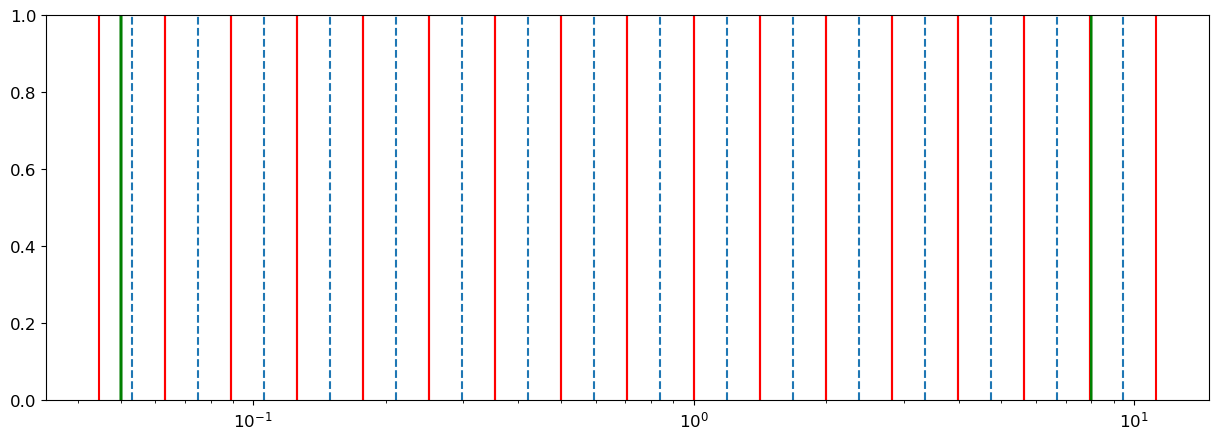

In [13]:
from functions.get_octave_bands import __get_octave_bands

f_lower, f_higher, f_center = __get_octave_bands(config['f_min'], config['f_max'], faction_of_octave=2, plot=True)

# cut first and last
f_lower, f_higher = f_lower[1:-1], f_higher[1:-1]

# reverse sorting
f_lower, f_higher = f_lower[::-1], f_higher[::-1]


## Main Code

In [16]:
# pre-calculate time intervals for loop based on starttime, endtime and specified time intervals
times = __get_time_intervals(config['tbeg'], config['tend'], config['interval_seconds'], config['interval_overlap'])

from tqdm.notebook import tqdm

# get the relevant information
for t1, t2 in tqdm(times):

    tsz = []
    tsn = []
    tse = []
    coo = []
    first = True


    # ____________________________________________
    # load translational data

    net, sta, loc, cha = config['tra_seed'].split(".")

    # read translational data
    try:
        try:
            tra = __read_from_sds(config['path_to_sds'], config['tra_seed'], t1, t2)
        except:
            pass

        try:
            tra = read(config['path_to_sds']+f"{config['tbeg'].year}/{net}/{sta}/{cha}.D/*",
                       starttime=t1,
                       endtime=t2,
                      )
        except:
            pass
    except:
        pass

    if config['verbose']:
        print(tra)

    # tra.plot(equal_scale=False);

    # ____________________________________________
    # load rotational data

    net, sta, loc, cha = config['rot_seed'].split(".")

    # read rotational data
    try:
        try:
            rot = __read_from_sds(config['path_to_sds'], config['rot_seed'], t1, t2)
        except:
            pass

        try:
            rot = read(config['path_to_sds']+f"{config['tbeg'].year}/{net}/{sta}/{cha}.D/*",
                       starttime=t1,
                       endtime=t2,
                       )
        except:
            pass
    except:
        pass

    if config['verbose']:
        print(rot)

    # rot.plot(equal_scale=False);


    # ____________________________________________
    # pre-process data

    rot_inv = read_inventory(config['path_to_inv_rot'])
    tra_inv = read_inventory(config['path_to_inv_tra'])

    # sort stream
    tra = tra.sort()
    tra = tra.reverse()

    # remove trend
    tra = tra.detrend("linear")

    # processing stream
    tra = tra.merge(method=1, fill_value='latest')
    # tra = tra.attach_response(tra_inv)
    # tra = tra.resample(sampling_rate=df, no_filter=False)
    # tra = tra.rotate(method='->ZNE', inventory=inv, components=['ZNE'])

    tra = tra.detrend("linear")

    tra = tra.filter('highpass', freq=0.005, zerophase=True)

    # tra =tra.remove_response(config['inv_tra'], water_level=10, output=config['tra_output'])

    tra = tra.detrend("linear")




    rot = rot.sort()
    rot = rot.reverse()

    rot = rot.merge(method=1, fill_value='latest')
    # rot = rot.attach_response(rot_inv)
    # rot = rot.rotate(method='->ZNE', inventory=inv2, components=['321'])

    # print("Offset vertical: %f"%(rot.select(component="*Z")[0].data.mean()) )
    # print("Offset East:     %f"%(rot.select(component="*E")[0].data.mean()) )
    # print("Offset North:    %f"%(rot.select(component="*N")[0].data.mean()) )

    # rot = rot.remove_sensitivity(config['inv_rot'])

    rot = rot.detrend("linear")

    rot = rot.filter('highpass', freq=0.005, zerophase=True)

    # rot = rot.resample(sampling_rate=df,no_filter=False)
    # rot = rot.interpolate(sampling_rate=df,starttime=start+1)

    rot = rot.sort()
    rot = rot.reverse()

    rot = rot.detrend("linear")

    # rot.plot(equal_scale=False);


###############################
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
###############################

    if tra[0].stats.endtime > rot[0].stats.endtime:
        rot = rot.trim(t1+1, rot[0].stats.endtime)
        tra = tra.trim(t1+1, rot[0].stats.endtime)
    else:
        rot = rot.trim(t1+1, tra[0].stats.endtime)
        tra = tra.trim(t1+1, tra[0].stats.endtime)


# in the folowing we are using horizontal components of velocity and acceleration
# consequently we have to correct them from local tilt effects before using it
# this is done via an estimation of the transferfunction

    #sz1.select(component="N")[0].data = tilt.tiltcorrect(sz1.select(component="N")[0],rots.select(component="E")[0])
    #sz1.select(component="E")[0].data = tilt.tiltcorrect(sz1.select(component="E")[0],rots.select(component="N")[0])

    acc = tra.copy()
    acc = acc.differentiate()

    if config['verbose']:
        acc

    # acc.plot(equal_scale=False);


###################################################################
# Start of calculations ...
###################################################################

    # and the parameter periods_per_window
    windows_l = rochade.rolode_estimator(f_lower, f_higher,
                                         config['periods_per_window'],
                                         config['vmin'],
                                         config['vmax'],
                                         config['trigger_params'],
                                        )
    if config['verbose']:
        windows_l.printlog()

    rot = rot.copy()

    #acc.trim(nstart,nend)
    #sz1.trim(nstart,nend)
    #rot.trim(nstart,nend)


    name = f"{sta}_{config['tbeg'].date}_{config['tend'].date}"
    config['filename'] = name

####################################################################
# LOVE WAVES
# Main processing step, window_estimation takes the
# vertical rotation rate, north acceleration and east acceleration
# and calculates the estimations
# LOVE WAVES
####################################################################

    if config['love_waves']:

        if config['body']:

            irot = rot.copy()
            irot.integrate()

            windows_l.window_estimation_love(irot[0],
                                             tra[1],
                                             tra[2],
                                             mask_value=config['mvalue'],
                                             body=config['body'],
                                             trigger=config['detrigger'],
                                             verbose=config['verbose'],
                                            )

            # define path where to save output:
            save_path_love = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-SV/"

        else:
            windows_l.window_estimation_love(rot.select(component="Z")[0],
                                             acc.select(component="N")[0],
                                             acc.select(component="E")[0],
                                             mask_value=config['mvalue'],
                                             trigger=config['detrigger'],
                                             verbose=config['verbose'],
                                            )

            save_path_love = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-Love/"

        # createt directories
        if not os.path.exists(save_path_love):
            os.makedirs(save_path_love)

        # write to file and log
        windows_l.write(save_path_love+"windows_l.pkl", config['firstRun'])
        windows_l.writelog(save_path_love+"info_l.log", config['firstRun'])

        config['save_path_love'] = save_path_love


###################################################################
# RAYLEIGH WAVES
# Main processing step, window_estimation takes the
# vertical acceleration, north and east rotation rate
# and calculates the estimations
# RAYLEIGH WAVES
###################################################################

    if config['rayleigh1_waves']:

        windows_r = rochade.rolode_estimator(f_lower, f_higher,
                                             config['periods_per_window'],
                                             config['vmin'],
                                             config['vmax'],
                                             config['trigger_params'],
                                            )
        if config['verbose']:
            windows_r.printlog()

        if config['body']:
            irot = rot.copy()
            irot.integrate()

            windows_r.window_estimation_rayleigh(tra[0],
                                                 irot[1],
                                                 irot[2],
                                                 mask_value=config['mvalue'],
                                                 body=config['body'],
                                                 trigger=config['detrigger'],
                                                 verbose=config['verbose'],
                                                )

            save_path_ray1 = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-SV1/"
        else:

            windows_r.window_estimation_rayleigh(acc.select(component="Z")[0],
                                                 rot.select(component="N")[0],
                                                 rot.select(component="E")[0],
                                                 mask_value=config['mvalue'],
                                                 trigger=config['detrigger'],
                                                 verbose=config['verbose'],
                                                )

            save_path_ray1 = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-Rayleigh/"

        # createt directories
        if not os.path.exists(save_path_ray1):
            os.makedirs(save_path_ray1)

        # write to file and log
        windows_r.write(save_path_ray1+"windows_r.pkl", config['firstRun'])
        windows_r.writelog(save_path_ray1+"info_r.log", config['firstRun'])

        config['save_path_rayleigh1'] = save_path_ray1

##################################################################
# RAYLEIGH WAVES
# Main processing step, window_estimation takes the
# vertical acceleration, north and east rotation rate
# and calculates the estimations
# RAYLEIGH WAVES
###################################################################

    if config['rayleigh2_waves']:

        windows_r2 = rochade.rolode_estimator(f_lower, f_higher,
                                              config['periods_per_window'],
                                              config['vmin'],
                                              config['vmax'],
                                              config['trigger_params'],
                                             )

        if config['verbose']:
            windows_r2.printlog()

        if config['body']:
            irot = rot.copy()
            irot.integrate()

            save_path_ray2 = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-SV2/"

            windows_r2.window_estimation_rayleigh2(tra,
                                                   irot.select(component="N")[0],
                                                   irot.select(component="E")[0],
                                                   body=config['body'],
                                                   mask_value=config['mvalue'],
                                                   trigger=config['detrigger'],
                                                   verbose=config['verbose'],
                                                  )

        else:

            save_path_ray2 = config['path_to_outdata']+f"ROLODE/VROMY_HH/{name}-Rayleigh2/"

            windows_r2.window_estimation_rayleigh2(acc,
                                                   rot.select(component="N")[0],
                                                   rot.select(component="E")[0],
                                                   body=config['body'],
                                                   mask_value=config['mvalue'],
                                                   trigger=config['detrigger'],
                                                   verbose=config['verbose'],
                                                  )

        # createt directories
        if not os.path.exists(save_path_ray2):
            os.makedirs(save_path_ray2)

        # write to file and log
        windows_r2.write(save_path_ray2+"windows_r2.pkl", config['firstRun'])
        windows_r2.writelog(save_path_ray2+"info_r2.log", config['firstRun'])

        config['save_path_rayleigh2'] = save_path_ray2


    config['firstRun'] = False


  0%|          | 0/35 [00:00<?, ?it/s]

In [19]:
###################################################################
# Postprocessing
##################################################################

if config['love_waves']:

    __postprocessing(config, wave_type="love")

if config['rayleigh1_waves']:

    __postprocessing(config, wave_type="rayleigh1")

if config['rayleigh2_waves']:

    __postprocessing(config, wave_type="rayleigh2")



-> load data: /home/andbro/kilauea-data/VelocityChanges/data/VROMY/ROLODE/VROMY_HH/VROMY_2024-02-25_2024-02-28-Love/windows_l.pkl
Calculating means and standard deviations...

  Now at frequency f = 6.69
  Now at frequency f = 4.73
  Now at frequency f = 3.35
  Now at frequency f = 2.37
  Now at frequency f = 1.68
  Now at frequency f = 1.19
  Now at frequency f = 0.84
  Now at frequency f = 0.60
  Now at frequency f = 0.42
  Now at frequency f = 0.30
  Now at frequency f = 0.21
  Now at frequency f = 0.15
  Now at frequency f = 0.11
  Now at frequency f = 0.08

Calculating KDEs and modes:

  Now at frequency f = 6.78
  Now at frequency f = 4.80
  Now at frequency f = 3.40
  Now at frequency f = 2.41
  Now at frequency f = 1.70
  Now at frequency f = 1.21
  Now at frequency f = 0.85
  Now at frequency f = 0.60
  Now at frequency f = 0.43
  Now at frequency f = 0.30
  Now at frequency f = 0.21
  Now at frequency f = 0.15
  Now at frequency f = 0.11
  Now at frequency f = 0.08


Calculat

In [18]:
config_dump = config

config_dump['tbeg'] = str(config_dump['tbeg'])
config_dump['tend'] = str(config_dump['tend'])

# store configurations
with open(config['path_to_sds']+f"{config['filename']}_config.yml", "w") as outfile:
    yaml.dump(config, outfile, default_flow_style=False, sort_keys=True)
